In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model = model.to(device)

In [102]:
with open('book.txt') as f:
    text_book = f.read()
    text_book = ' '.join(text_book.split())
    tokens_str_book = tokenizer.tokenize(text_book)
    input_ids_book = tokenizer(text_book, return_tensors='pt').input_ids[0]

In [4]:
text = "hello how are you doing the cat said to the king and now the king was upset because he doesn't know what he doesn't know"
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs.input_ids.to(device)
print(f"Number of input tokens: {input_ids.shape[-1]}")
# outputs = model(inputs.input_ids, past_key_values=torch.randn(6, 2, 1, 12, 20, 64))
# past_key_values = torch.randn(6, 2, 1, 12, 20, 64)
past_key_values = None
# outputs = model.forward(input_ids=inputs.input_ids, past_key_values=past_key_values, output_attentions=True)

Number of input tokens: 27


In [10]:
text = "hello how are you doing cat proved that"
a = tokenizer.tokenize(text)
print(len(a))
print(a)
a = tokenizer.encode(text)
print(len(a))
print(a)

8
['hello', 'Ġhow', 'Ġare', 'Ġyou', 'Ġdoing', 'Ġcat', 'Ġproved', 'Ġthat']
8
[31373, 703, 389, 345, 1804, 3797, 8302, 326]


In [ ]:
# visualize 4th layer, all heads
# visualize all layers, first head

In [ ]:
# turn off layer norm and see the distribution of K's

# Am.sum(dim=-1) should be sparse, because only some words should be calling on the memories

# affect of adaptive alpha on the collapsing problem?

# do something about dead memories: grow the alpha step size if the memory is not being used ever (dead memory)

In [36]:
a = torch.randn(100, 768).to(device)
Q, K, V = model.transformer.h[0].attn.c_attn(a).split(768, dim=-1)
Q = Q.reshape(-1, 12, 64).permute(1, 0, 2)
K = K.reshape(-1, 12, 64).permute(1, 0, 2)

In [37]:
A = Q@K.transpose(-1, -2)
A.shape

torch.Size([12, 100, 100])

In [43]:
[A[i].mean().item() for i in range(12)]

[-7.324004650115967,
 30.20040512084961,
 -0.05420956760644913,
 15.586871147155762,
 3.028754711151123,
 36.700958251953125,
 -2.2576241493225098,
 -3.317286968231201,
 -1.8914519548416138,
 -5.813215732574463,
 7.302803039550781,
 0.715450644493103]

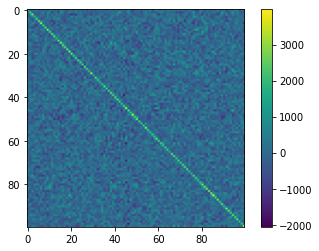

In [44]:
plt.imshow(to_np(A[1]))
plt.colorbar()

In [6]:
hms = [HopfieldMemory((1, 12, 20, 64), alpha=0.5, use_adaptive_alpha=False, opt='sgd', lr=1.0) for i in range(6)]
for hm in hms:
    hm.to(device)

In [8]:
ak = {'debug': True, 'layer': [], 'hms': hms}
akl = ak['layer']
outputs = model.forward(input_ids=input_ids, past_key_values=None, output_attentions=True, ak=ak)

In [111]:
A = akl[-1]['A']
A_sm = akl[-1]['A_sm']
Q, K, V = akl[-1]['QKV']

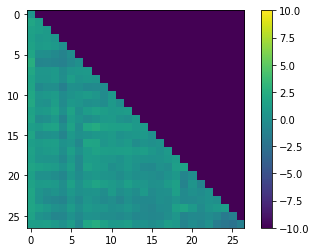

In [112]:
plt.imshow(to_np(A[0, 0]), vmin=-10, vmax=10)
plt.colorbar()

In [113]:
K.shape, hm.Km.shape

(torch.Size([1, 12, 27, 64]), torch.Size([1, 12, 20, 64]))

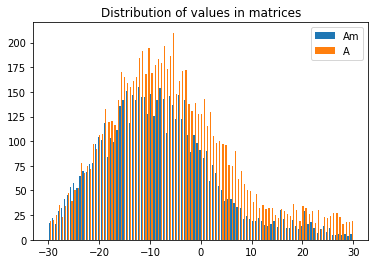

In [114]:
Km = torch.randn(1, 12, 20, 64).to(Q)
Km = (Km+K.mean(dim=-2, keepdim=True))*K.std(dim=-2, keepdim=True)
A = Q@K.transpose(-1, -2)
Am = Q@Km.transpose(-1, -2)
plt.title('Distribution of values in matrices')
plt.hist([to_np(Am.flatten()), to_np(A.flatten())], bins=np.linspace(-30, 30, 100), label=['Am', 'A'])
plt.legend()
plt.show()

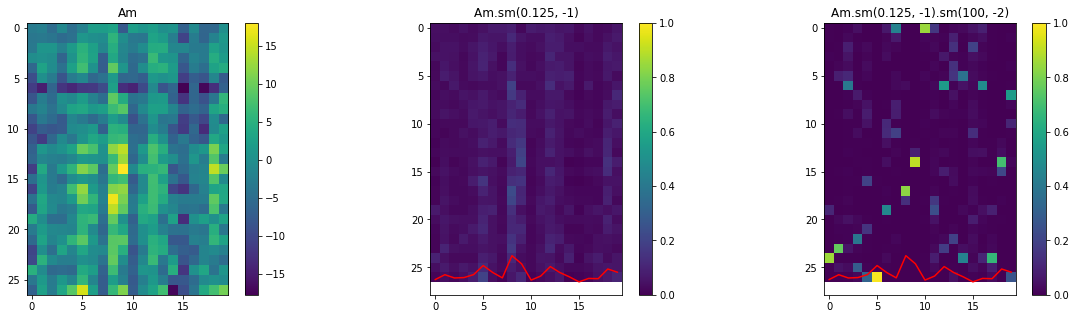

In [115]:
viz.viz_Am(Am[0,0], beta1=1/8, beta2=100)

  0%|          | 0/48 [00:00<?, ?it/s]

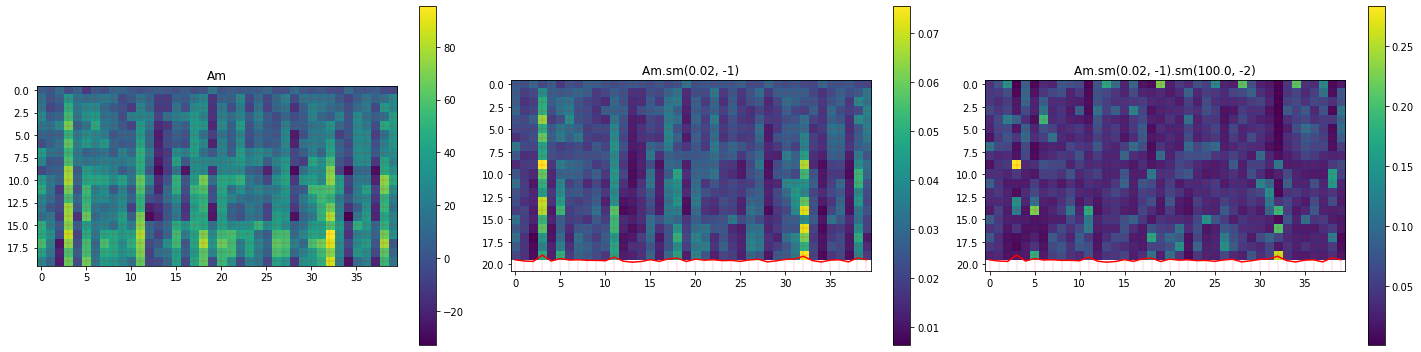

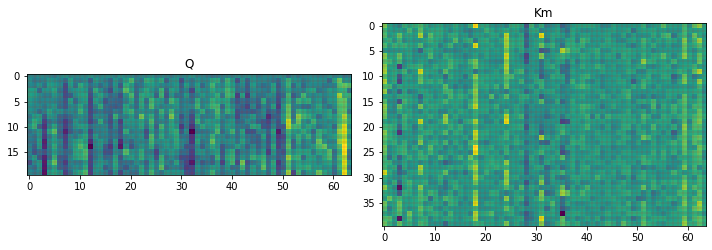

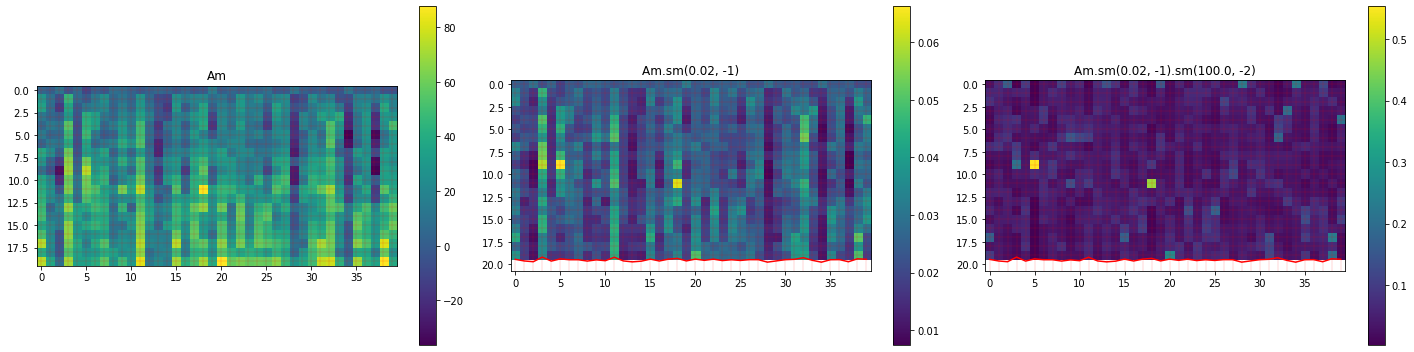

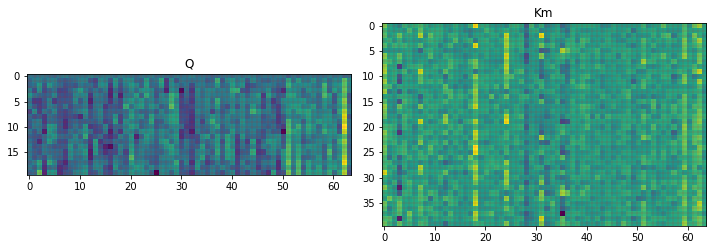

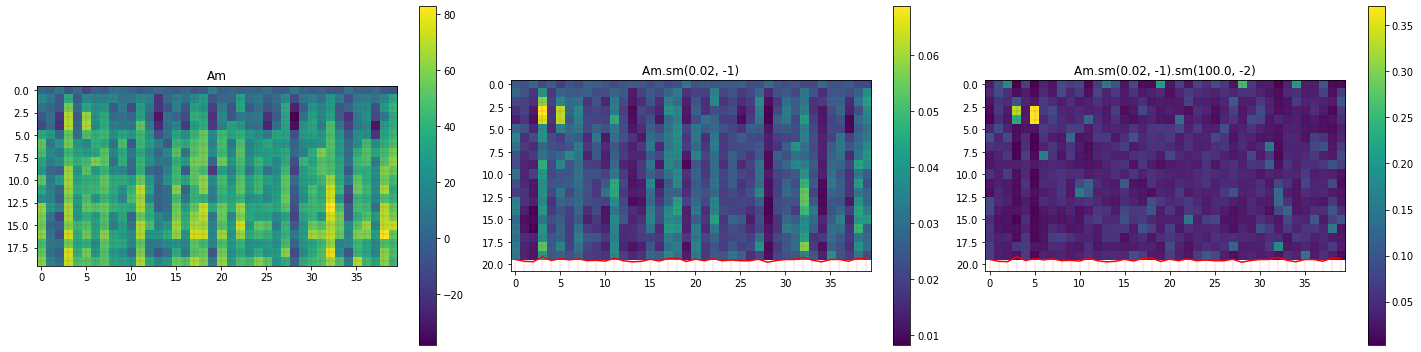

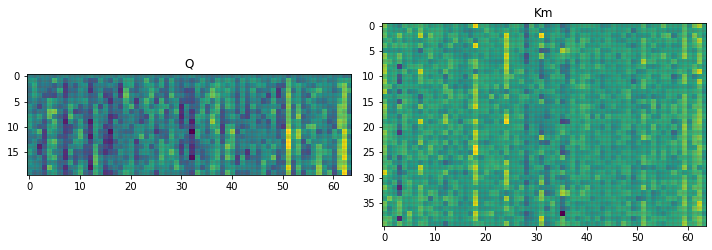

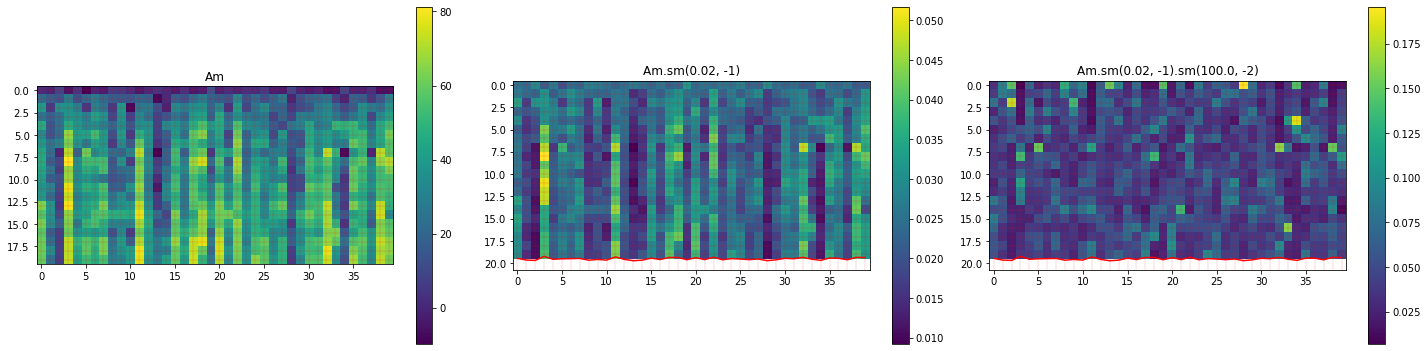

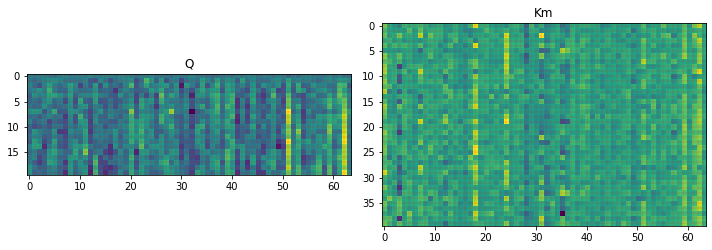

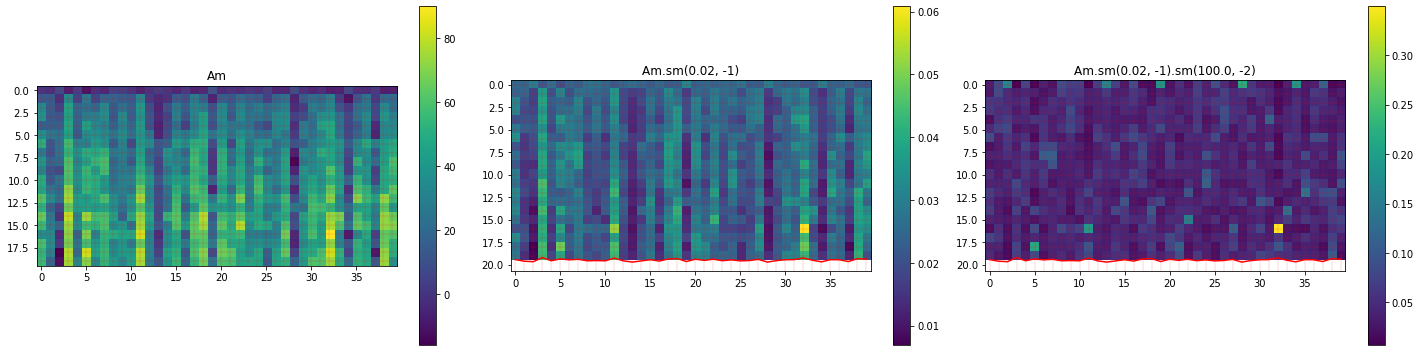

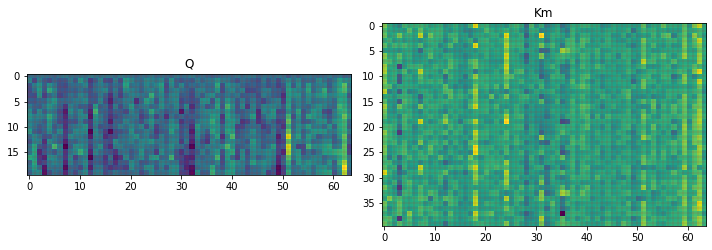

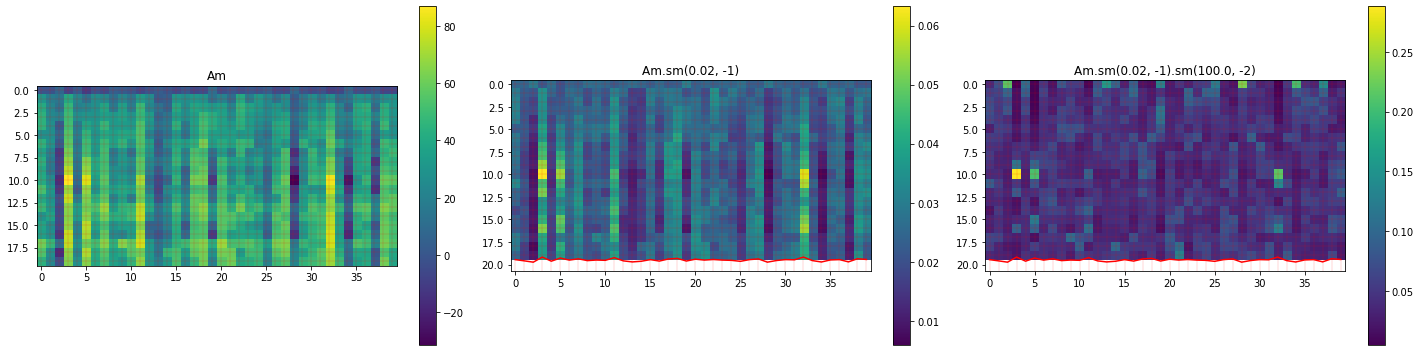

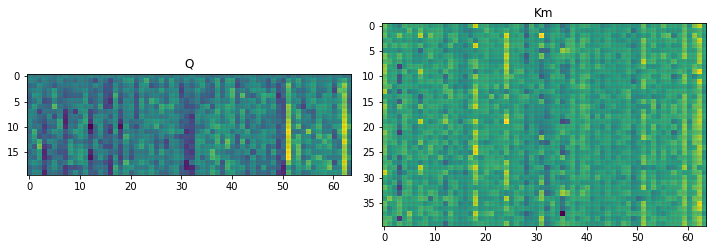

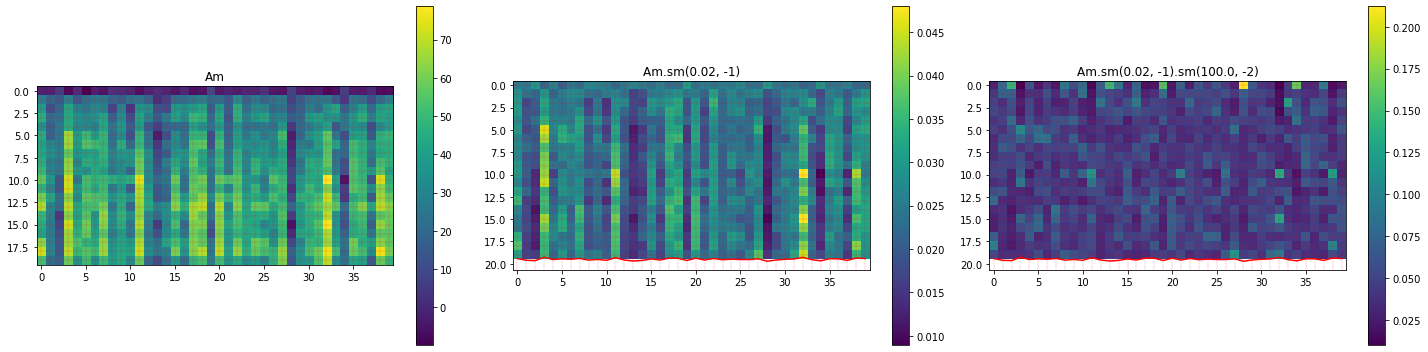

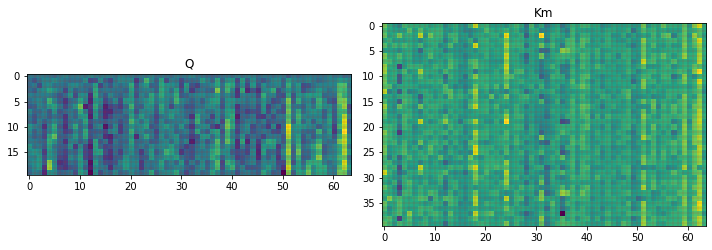

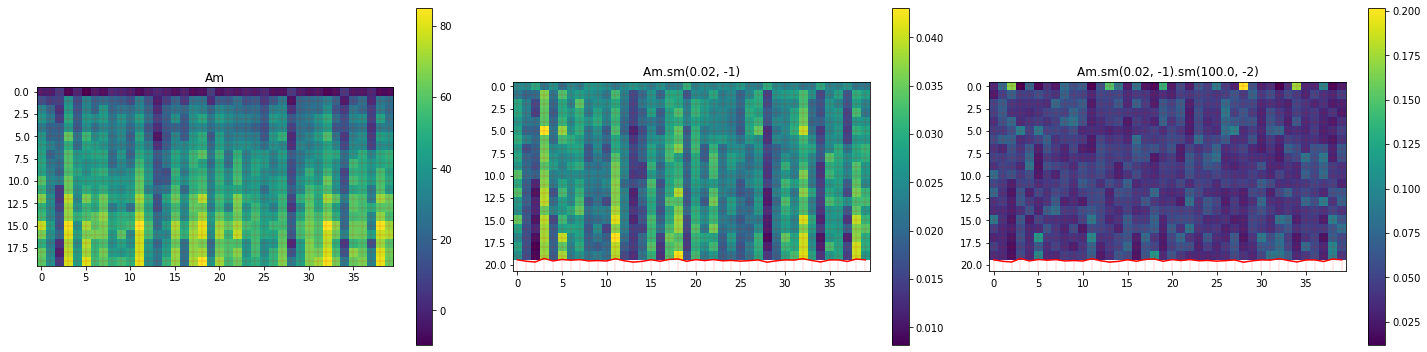

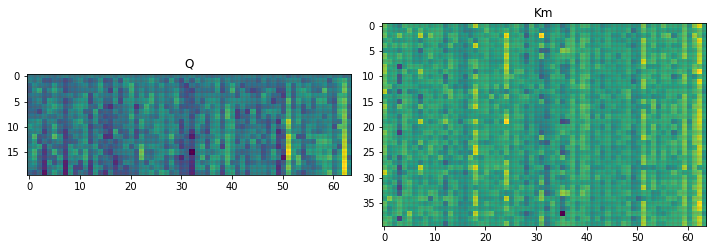

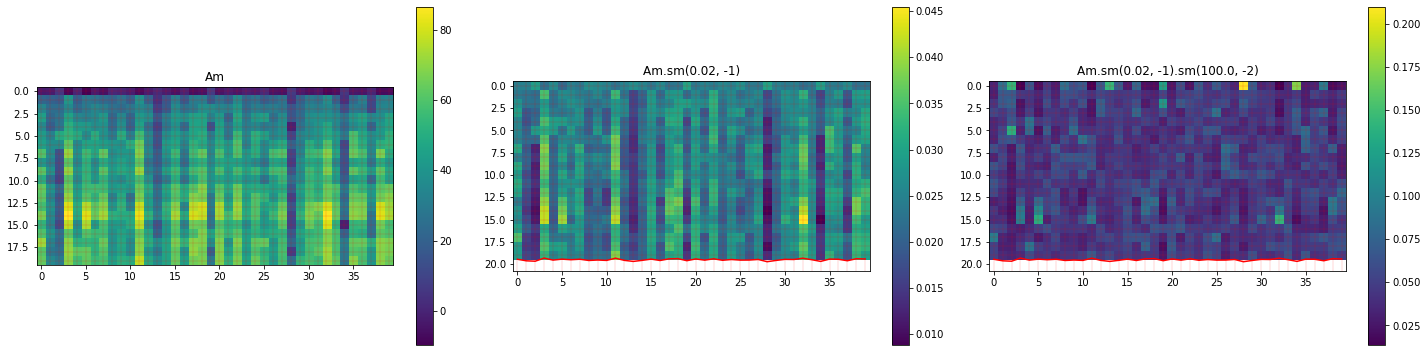

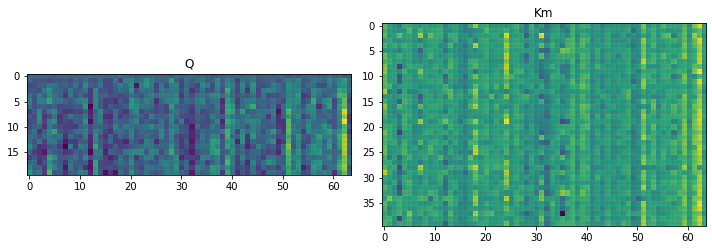

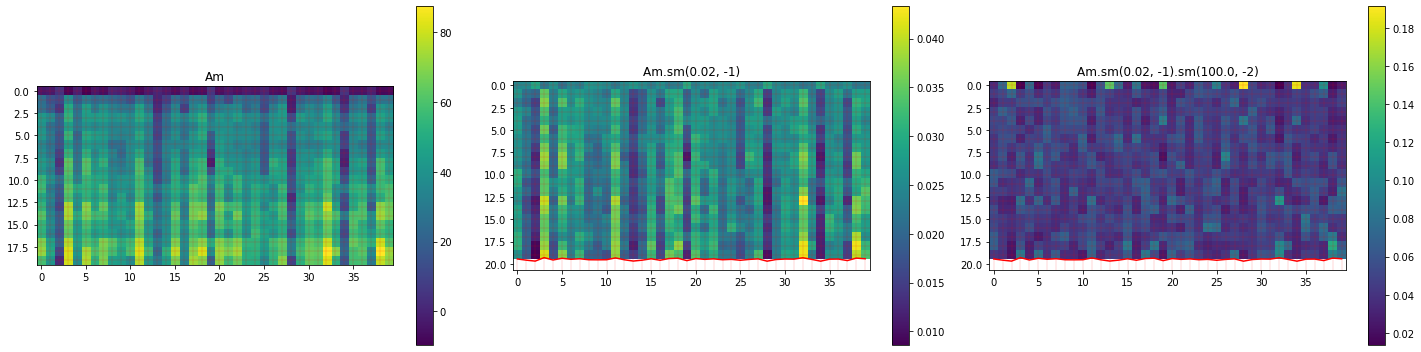

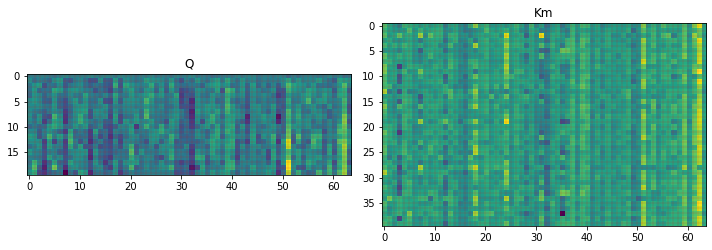

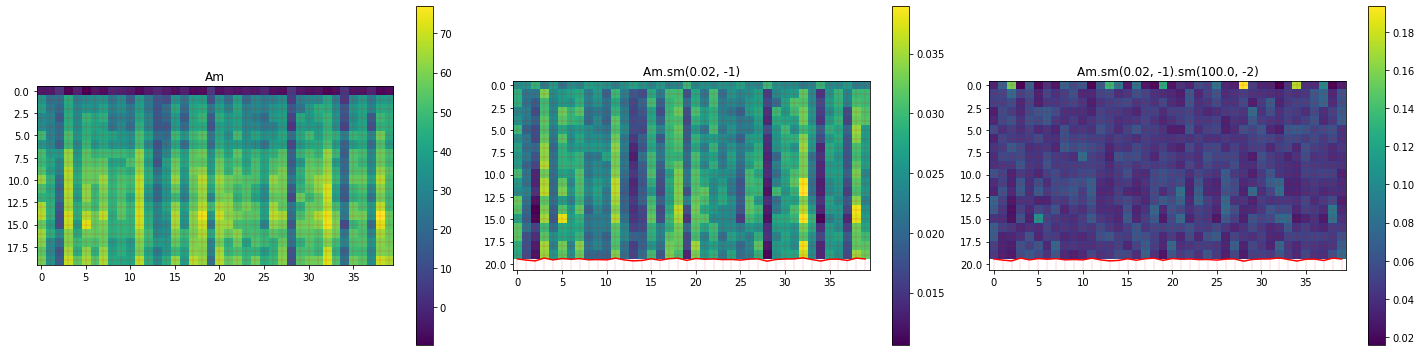

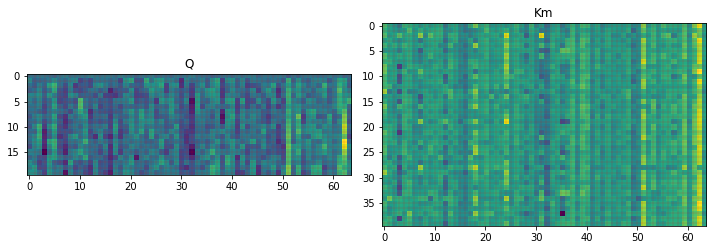

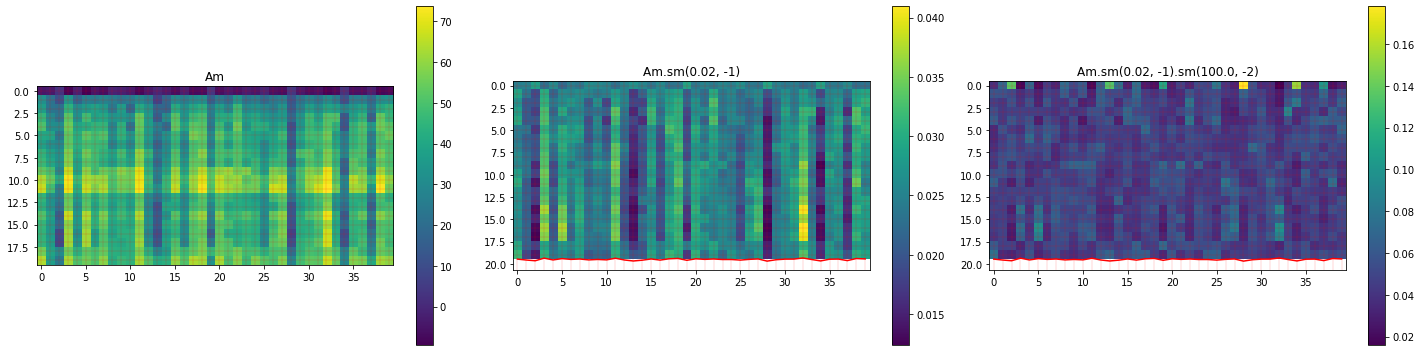

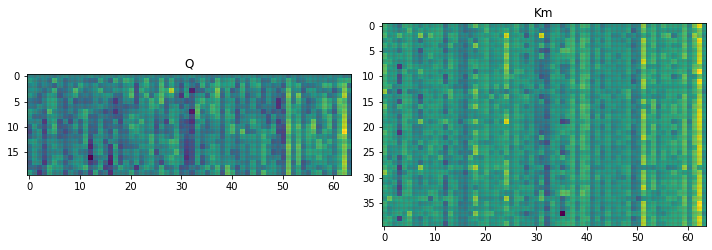

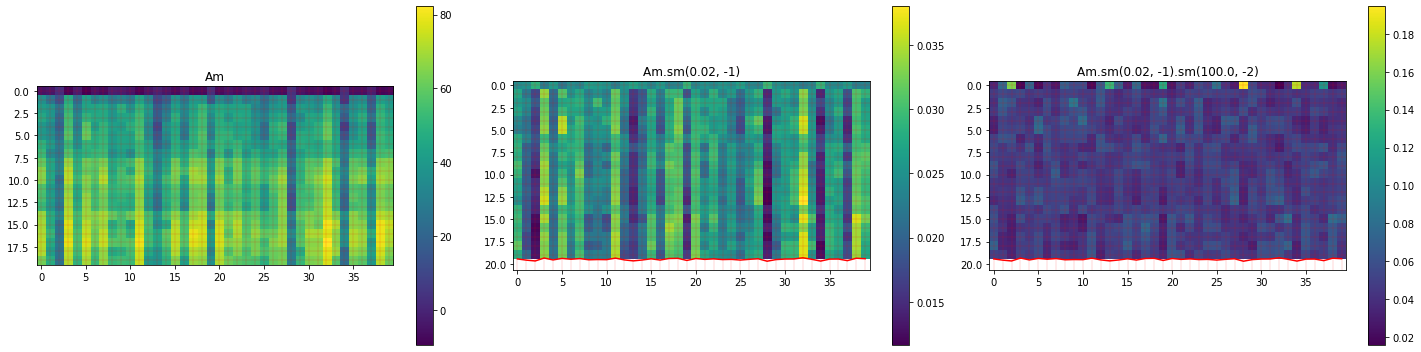

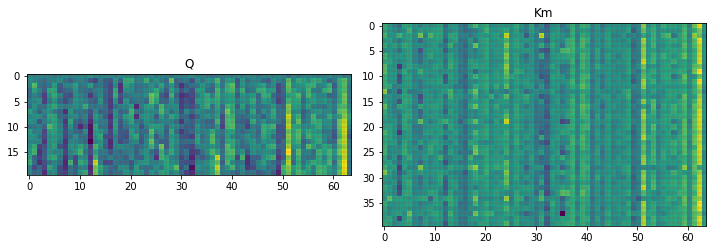

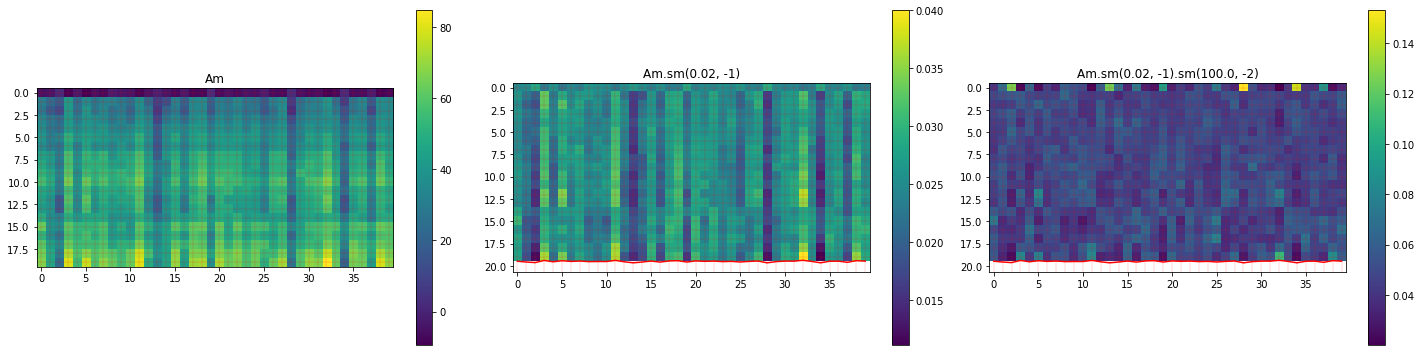

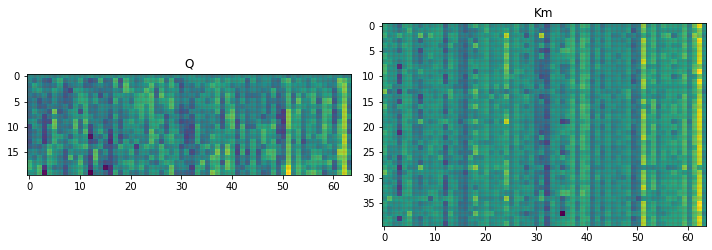

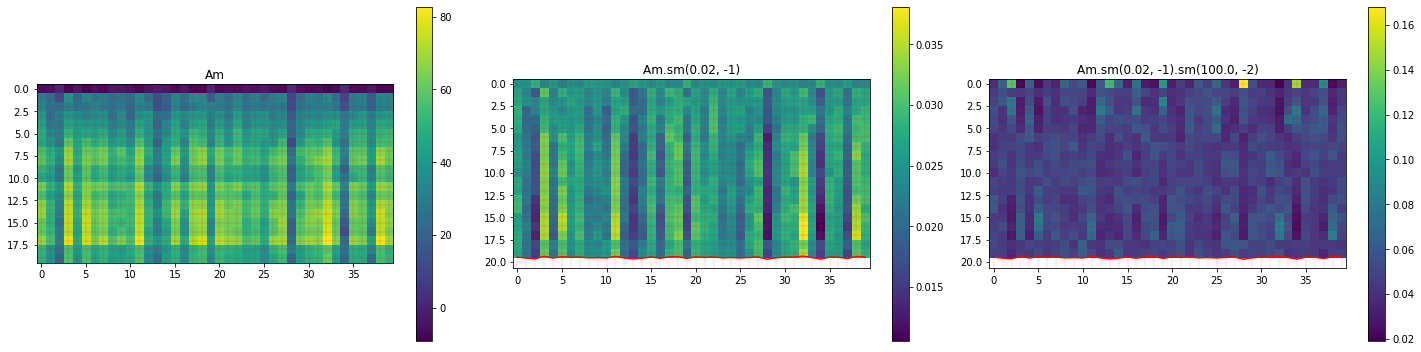

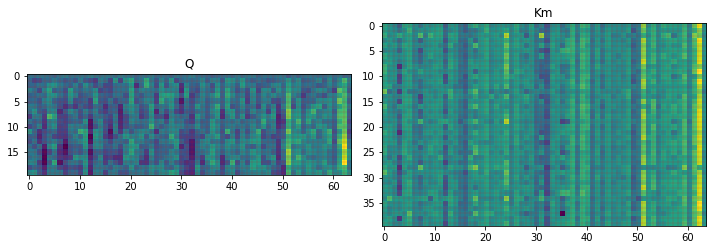

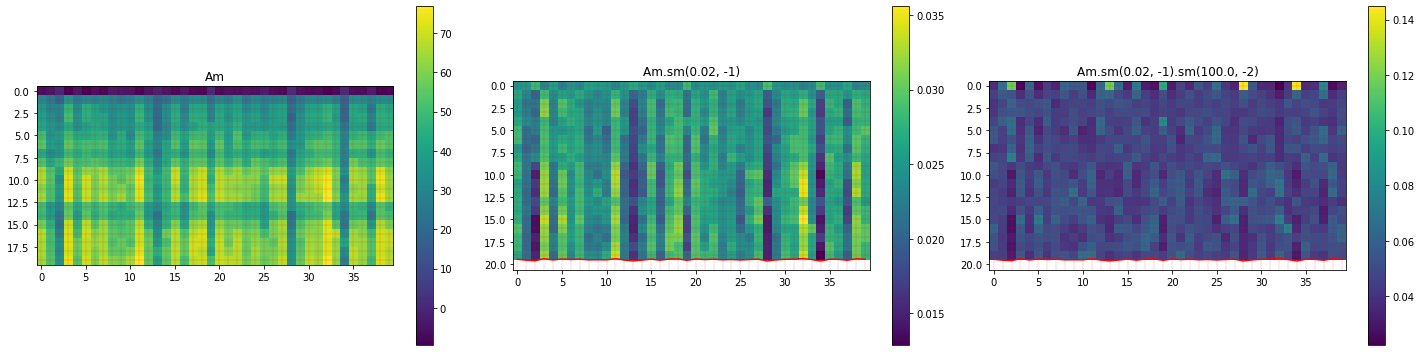

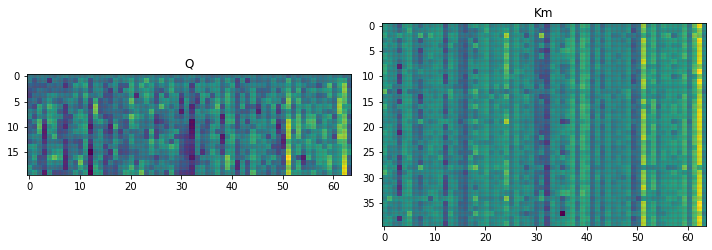

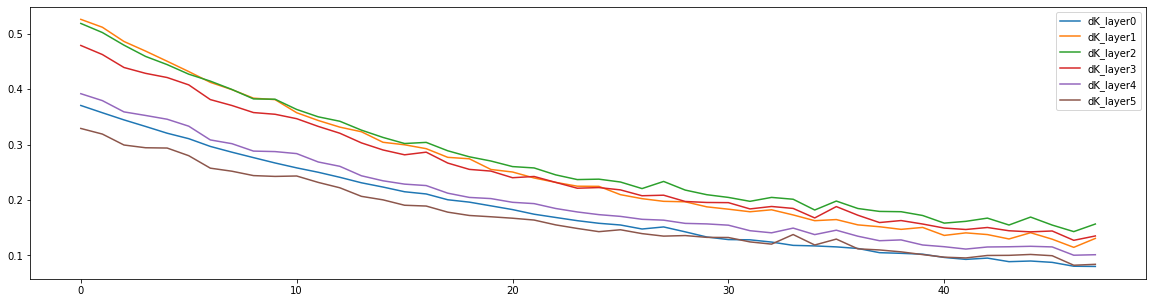

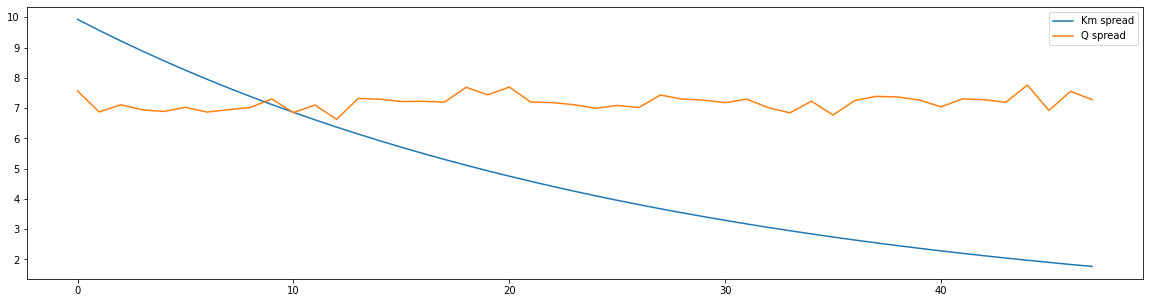

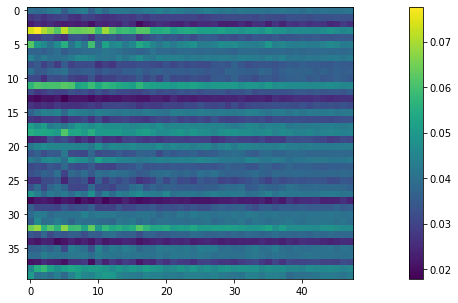

In [303]:
with open('book.txt') as f:
    text_book = f.read()
    text_book = ' '.join(text_book.split())

def experiment(tokenizer, model, text=None, context_length=100, stride=1, device='cpu', wandb=None, do_viz=True):
    if text is None:
        text = text_book
        
    max_length = model.config.n_positions
    max_length = context_length
    
    strs_all = tokenizer.tokenize(text)
    all_tokens = tokenizer(text, return_tensors='pt')
    encodings = all_tokens
    
    model = model.to(device)
    
    memory_size = 40
    beta1, beta2 = 1/8., 100.
    beta1, beta2 = 1/50., 100.
    alpha = 0.1
    use_adaptive_alpha = False
    alpha = 1.5
    use_adaptive_alpha = True
    
    hms = [HopfieldMemory((1, 12, memory_size, 64), alpha=alpha, use_adaptive_alpha=use_adaptive_alpha, opt='sgd', lr=1.0) for i in range(6)]
        
    input_ids = encodings.input_ids[:, 1000: 2000].to(device)
    ak = {'debug': True, 'layer': [], 'hms': hms}
    outputs = model(input_ids, labels=None, ak=ak)
    for layer_idx, hm in enumerate(hms):
        hm.to(device)
        hm.reset(1.)
        Q, K, V = ak['layer'][layer_idx]['QKV']
        # hm.Km.data[...] = hm.Km.data[...]*Q.std(dim=-1, keepdim=True)+Q.mean(dim=-1, keepdim=True)
        hm.Km.data[...] = hm.Km.data[...]*Q.std(dim=-2, keepdim=True)+Q.mean(dim=-2, keepdim=True)
    

    nlls = []
    # for i in tqdm(range(0, encodings.input_ids.size(1), stride)):
    graph = []
    Km_spread = []
    Q_spread = []
    
    step_data = defaultdict(lambda: [])
    
    # for i in tqdm(range(40, 300, stride)):
    for ii, i in enumerate(tqdm(range(40, 1000, stride))):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, encodings.input_ids.size(1))
        trg_len = end_loc - i  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc: end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        
        strs_context = strs_all[begin_loc: end_loc]
        
        with torch.no_grad():
            ak = {'debug': True, 'layer': [], 'hms': hms}
            outputs = model(input_ids, labels=target_ids, ak=ak)
            nll_i = outputs[0] * trg_len
            
            for layer_idx in range(6):
                akl = ak['layer'][layer_idx]
                hm = hms[layer_idx]
                Km = hm.Km
                A = akl['A']
                A_sm = akl['A_sm']
                O = akl['O']
                Q, K, V = akl['QKV']
                
                Km = hm.Km
                Am = Q@Km.transpose(-1, -2)
                QQ = Q@Q.transpose(-1, -2)
                QK = Q@K.transpose(-1, -2)
                # print(Am.min().item(), Am.mean().item(), Am.max().item())
                
                Km_target = Q
                # Km_target = A_sm@K
                hm.set_target_with_data(Q=Km_target, O=O, dist_metric='dot', 
                                        beta1=beta1, beta2=beta2 , beta3=None)
                ua = hm.used_alpha
                step_data[f'ua_layer{layer_idx}'].append(ua)
                
                if i%30==0 and layer_idx==3 and do_viz:
                    viz.viz_Am(Am[0,0], beta1=beta1, beta2=beta2)
                    plt.tight_layout(); plt.show()
                    viz.viz_Q_Km(Q[0,0], Km[0,0])
                    plt.tight_layout(); plt.show()
                    
                Kmp = Km.clone()
                hm.step()
                dK = (Km-Kmp).norm(dim=-1).mean().item()
                step_data[f'dK_layer{layer_idx}'].append(dK)
            
                    
                    # plt.figure(figsize=(15, 5))
                    # plt.subplot(131)
                    # plt.imshow(to_np(Am[0,0, :, :])); plt.colorbar()
                    # plt.subplot(132)
                    # a = Am[0,0, :, :]
                    # b = (beta1*a).softmax(dim=-1)
                    # plt.imshow(to_np(b)); plt.colorbar()
                    # plt.subplot(133)
                    # c = (beta2*(beta1*a).softmax(dim=-1)).softmax(dim=-2)
                    # plt.imshow(to_np(c)); plt.colorbar()
                    # # plt.imshow(to_np(hm.Km[0,0, :, :]))
                    # plt.show()
#             # if i>0 and i%200==0:
#                 # break
                
            a = (hm.Km[..., None, :, :]-hm.Km[..., :, None, :]).norm(dim=-1)
            step_data['Km_spread'].append(a.mean().item())
            a = (Q[..., None, :, :]-Q[..., :, None, :]).norm(dim=-1)
            step_data['Q_spread'].append(a.mean().item())
            
            # if a.mean().item()< 6:
                # print(tokenizer.convert_tokens_to_string(strs_context))
            
#             graph.append([
#                 [Am.min().item(), QQ.min().item(), QK.min().item()],
#                 [Am.mean().item(), QQ.mean().item(), QK.mean().item()],
#                 [Am.max().item(), QQ.max().item(), QK.max().item()],
#             ])
            

#         if not torch.isnan(neg_log_likelihood):
#             nlls.append(neg_log_likelihood)
#         else:
#             print('Found NaN value')
            
#         if i%40==0:
#             plt.figure(figsize=(20,10))
#             plt.suptitle(f'Iteration {i}')
#             plt.subplot(221); plt.title('Am = QKm^T')
#             plt.imshow(to_np(Am[0,0])); plt.colorbar()
#             plt.subplot(222); plt.title('A = QK^T')
#             plt.imshow(to_np(QK[0,0])); plt.colorbar()

#             plt.subplot(223); plt.title('Am.sm(-1)')
#             plt.imshow(to_np((beta1*Am[0,0]).softmax(dim=-1))); plt.colorbar()
#             plt.subplot(224); plt.title('Am.sm(-1).sm(-2)')
#             plt.imshow(to_np((beta2*(beta1*Am[0,0]).softmax(dim=-1)).softmax(dim=-2))); plt.colorbar()
#             plt.show()
            
#             plt.title('Km');
#             plt.imshow(to_np(Km[0,0]))
#             plt.show()
    plt.figure(figsize=(20, 5))
    a = np.array([step_data[f'dK_layer{layer_idx}'] for layer_idx in range(6)]).T
    plt.plot(a, label=[f'dK_layer{layer_idx}' for layer_idx in range(6)])
    plt.legend()
    plt.show()
            
    plt.figure(figsize=(20,5))
    plt.plot(step_data['Km_spread'], label='Km spread')
    plt.plot(step_data['Q_spread'], label='Q spread')
    plt.legend()
    plt.show()
    
    head_idx = 0
    layer_idx = 3
    plt.figure(figsize=(20, 5))
    a = torch.stack(step_data[f'ua_layer{layer_idx}'])[:, 0, head_idx, :, 0]
    plt.imshow(to_np(a).T); plt.colorbar()
    plt.show()
    
#     plt.figure(figsize=(20,5))
#     graph = np.array(graph).swapaxes(-1, -2)
#     plt.plot(graph[:, 0, 1], c='r', label='Am values')
#     plt.plot(graph[:, 1, 1], c='g', label='QQ values')
#     plt.plot(graph[:, 2, 1], c='b', label='Qk values')
#     # plt.plot(np.array(graph), label=['Am', 'QQ', 'QK'])
#     plt.legend()
#     plt.show()

torch.manual_seed(1)
experiment(tokenizer, model, context_length=20, stride=20, device=device, do_viz=True)

In [337]:
layer_idx = 3
head_idx = 0

token_idx = 0
context_length = 40
n_memories = 80

In [338]:
ak = {'debug': True, 'layers': [], 'hms': hms}
input_ids = input_ids_book[None, token_idx:token_idx+context_length].to(device)
outputs = model.forward(input_ids=input_ids, output_attentions=True, ak=ak)
akl = ak['layers'][layer_idx]
A = akl['A']
A_sm = akl['A_sm']
Q, K, V = akl['QKV']
Q, K, V = (a[0, head_idx] for a in (Q, K, V))

In [339]:
hm = HopfieldMemory((n_memories, 64), alpha=0.4, use_adaptive_alpha=False, opt='sgd', lr=1.0).to(Q.device)
hm.reset(1.)
hm.Km.data[:, :] = hm.Km.data[:, :]*Q.std(dim=0)+Q.mean(dim=0)

In [340]:
a = hm.Km.data.clone()
print((a[:, None, :] - a[None, :, :]).norm(dim=-1).mean())
a = Q
print((a[:, None, :] - a[None, :, :]).norm(dim=-1).mean())

tensor(11.1512, device='cuda:0')
tensor(10.9441, device='cuda:0', grad_fn=<MeanBackward0>)


In [341]:
Q.shape, hm.Km.shape

(torch.Size([40, 64]), torch.Size([80, 64]))

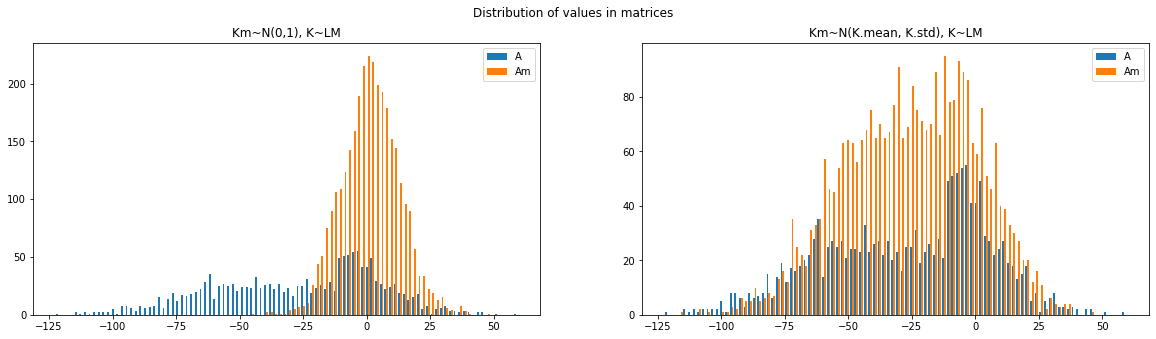

In [342]:
torch.manual_seed(3)
hm = HopfieldMemory((n_memories, 64), alpha=1., use_adaptive_alpha=True, opt='sgd', lr=1.0).to(Q)
# hm = HopfieldMemory((n_memories, 64), alpha=0.05, use_adaptive_alpha=False, opt='sgd', lr=1.0).to(Q.device)
hm.reset(1.)

A = Q@K.T
Am = Q@hm.Km.T

plt.figure(figsize=(20, 5))
plt.subplot(121); plt.title('Km~N(0,1), K~LM')
plt.hist([to_np(A.flatten()), to_np(Am.flatten())], bins=100, label=['A', 'Am']); plt.legend()

hm.Km.data[:, :] = hm.Km.data[:, :]*K.std(dim=0)+K.mean(dim=0)
# hm.Km.data[:, :] = (hm.Km.data[:, :]+K.mean(dim=0))*K.std(dim=0)
# hm.Km.data[:, :] = Q[torch.randint(len(Q), (len(hm.Km), ))]

A = Q@K.T
Am = Q@hm.Km.T

plt.subplot(122); plt.title('Km~N(K.mean, K.std), K~LM')
plt.hist([to_np(A.flatten()), to_np(Am.flatten())], bins=100, label=['A', 'Am']); plt.legend()
plt.suptitle('Distribution of values in matrices')
plt.show()



  0%|          | 0/5000 [00:00<?, ?it/s]

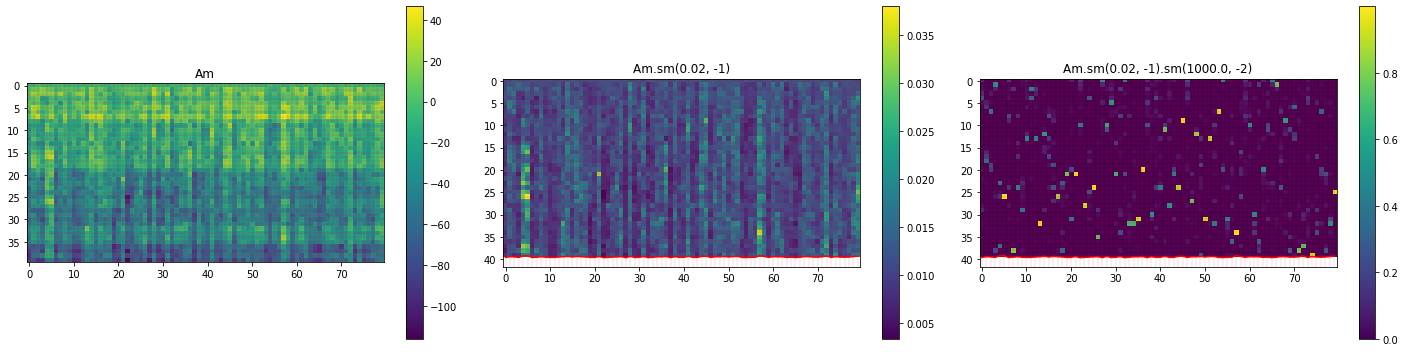

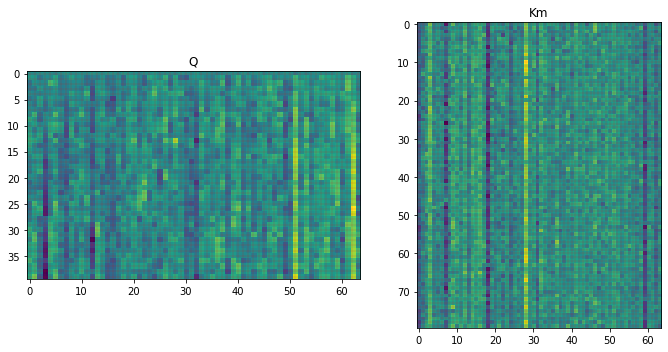

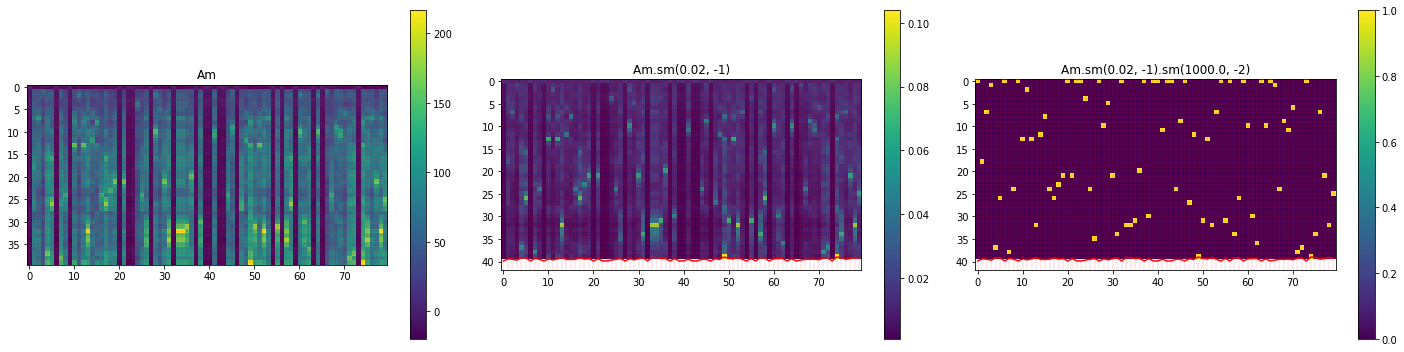

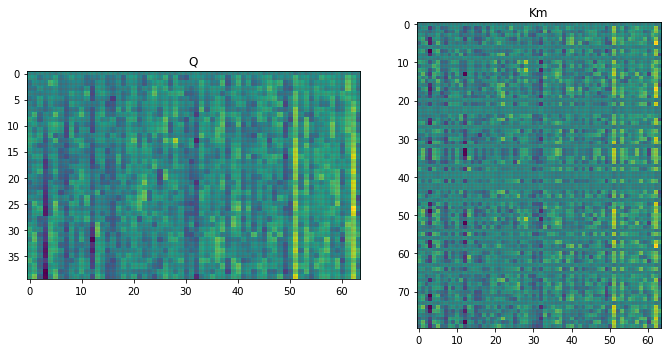

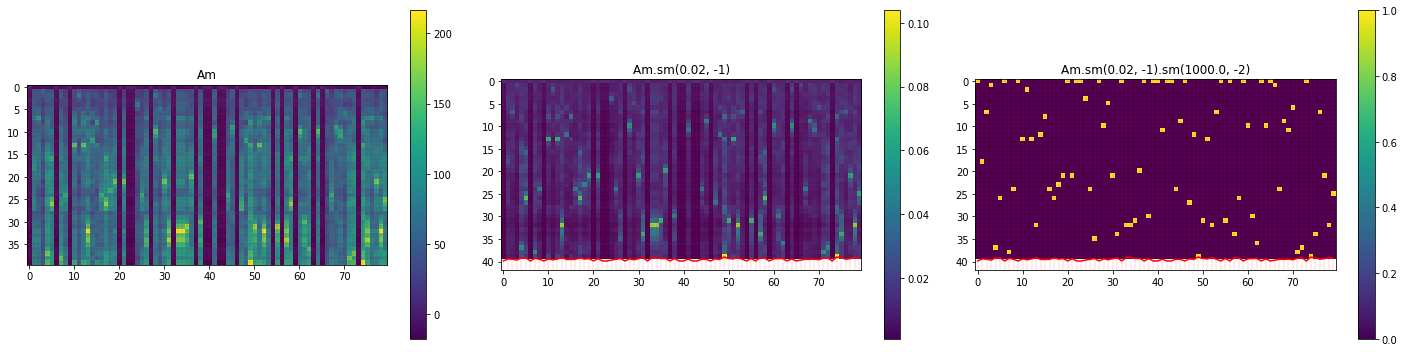

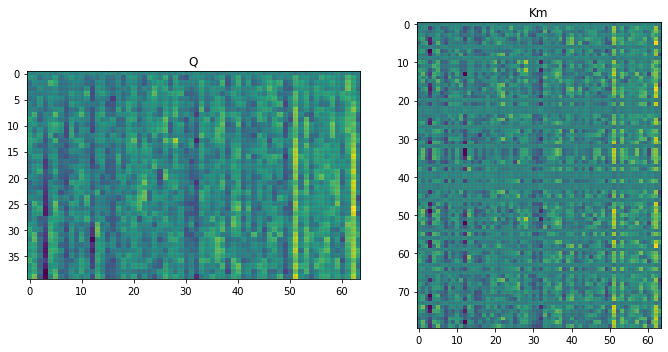

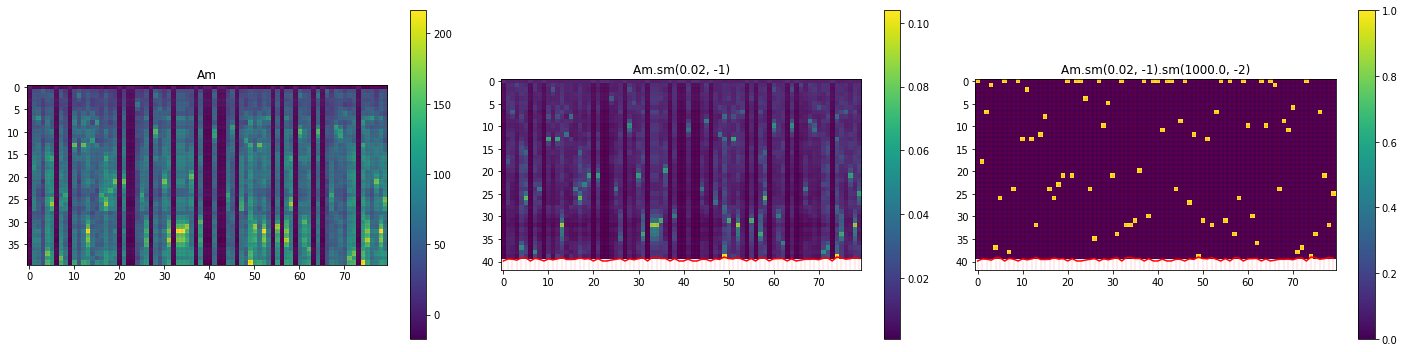

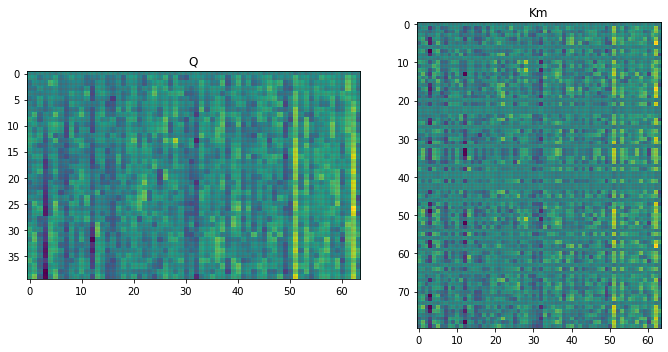

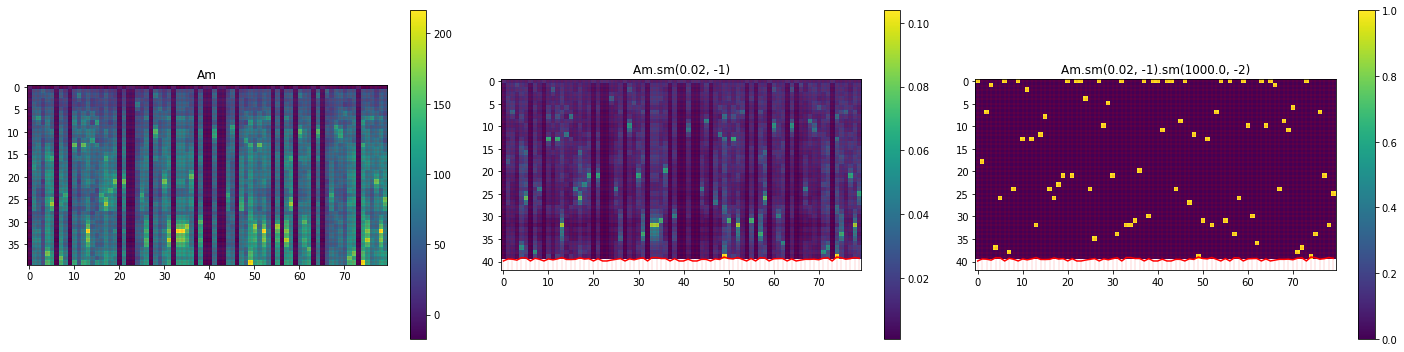

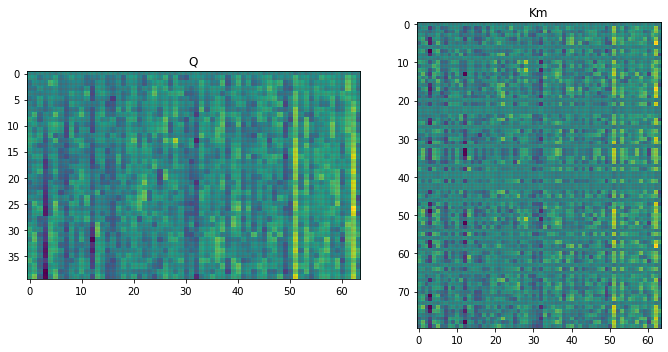

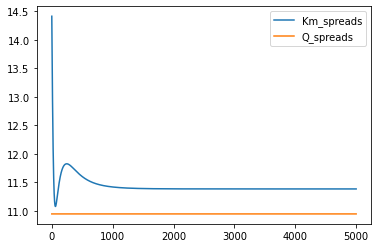

In [343]:
# beta1, beta2 = 1/8., 100.
beta1, beta2 = 1/50., 1000.

steps = defaultdict(lambda: [])

n_iters = 5000
for i in tqdm(range(n_iters)):
    Km = hm.Km
    A = Q@K.transpose(-1, -2)
    Am = Q@Km.transpose(-1, -2)
    
    steps['A_means'].append(A.mean().item())
    steps['A_maxes'].append(A.max().item())
    
    steps['Am_means'].append(Am.mean().item())
    steps['Am_maxes'].append(Am.max().item())
    a = (Km[:, None, :] - Km[None, :, :]).norm(dim=-1)
    steps['Km_spreads'].append(a.mean().item())
    a = (Q[:, None, :] - Q[None, :, :]).norm(dim=-1)
    steps['Q_spreads'].append(a.mean().item())
    
    steps['Km'].append(Km.clone())
    steps['Am'].append(Am.clone())
    
    if i%(n_iters//5)==0:
        viz.viz_Am(Am, beta1=beta1, beta2=beta2)
        plt.tight_layout(); plt.show()
        
        viz.viz_Q_Km(Q, hm.Km)
        plt.tight_layout(); plt.show()
        
    hm.set_target_with_data(Q, O=None, dist_metric='dot', beta1=beta1, beta2=beta2, beta3=None)
    hm.step()
    
plt.plot(steps['Km_spreads'], label='Km_spreads')
plt.plot(steps['Q_spreads'], label='Q_spreads')
plt.legend()
plt.show()



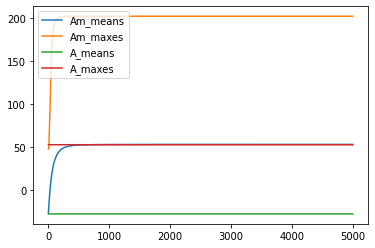

In [259]:
plt.plot(steps['Am_means'], label='Am_means')
plt.plot(steps['Am_maxes'], label='Am_maxes')
plt.plot(steps['A_means'], label='A_means')
plt.plot(steps['A_maxes'], label='A_maxes')
plt.legend()
plt.show()

In [260]:
Am = torch.stack(steps['Am'])
Ams = sm(Am, beta1, dim=-1)
Amss = sm(Ams, beta2, dim=-2)

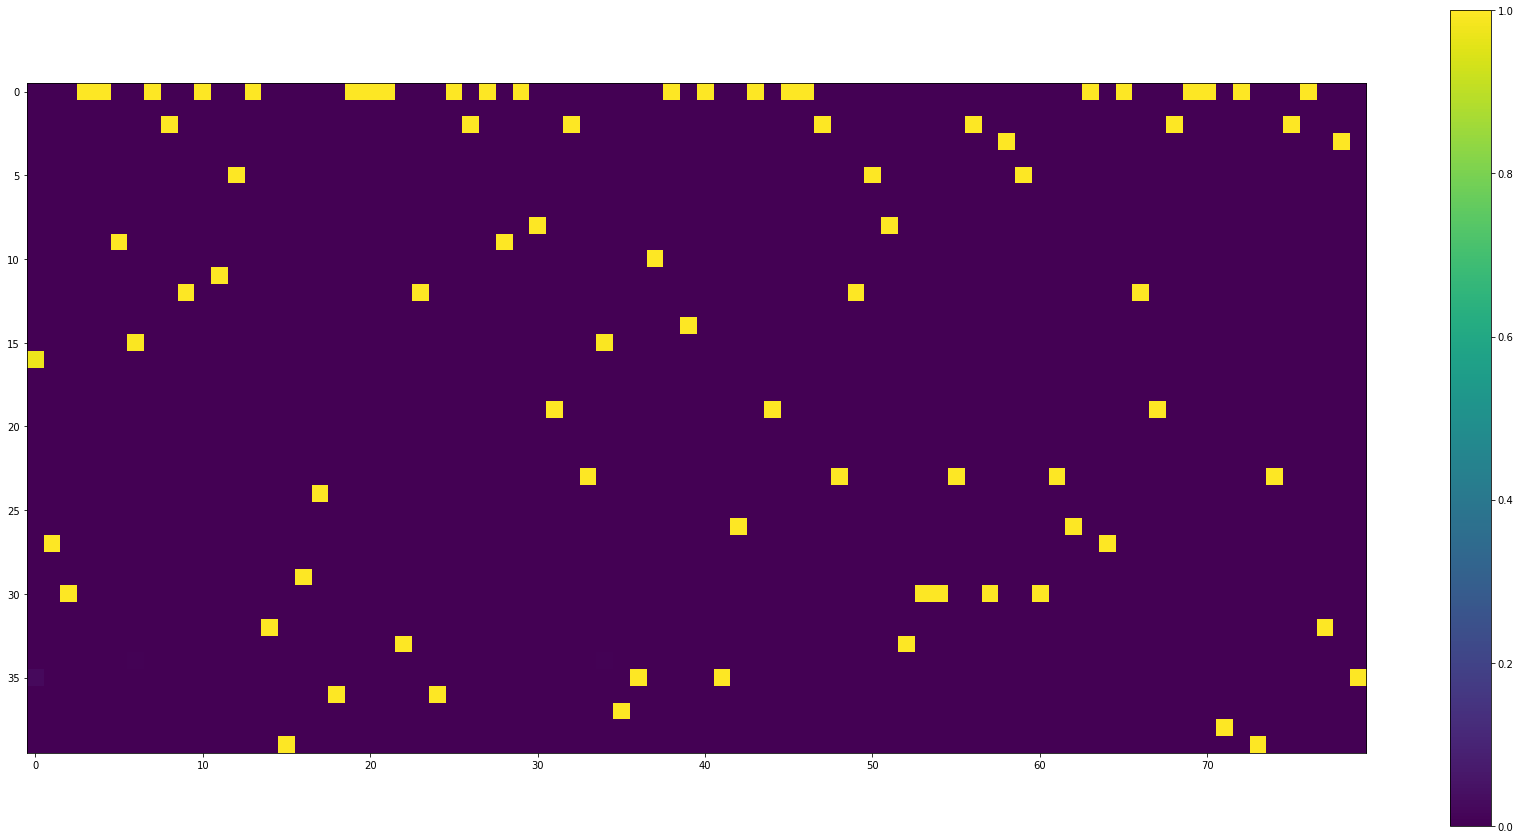

In [261]:
plt.figure(figsize=(30, 15))
plt.imshow(to_np(Amss[-1]))
plt.colorbar()

$$D_c = $$

In [245]:
alpha_avg = Ams.mean(dim=-2).mean(dim=0)
alpha_std = Ams.mean(dim=-2).std(dim=0)

Text(0, 0.5, 'Memory alpha std')

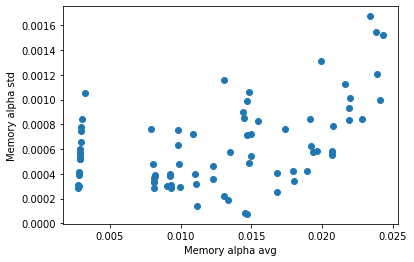

In [246]:
plt.scatter(to_np(alpha_avg), to_np(alpha_std))
plt.xlabel('Memory alpha avg')
plt.ylabel('Memory alpha std')

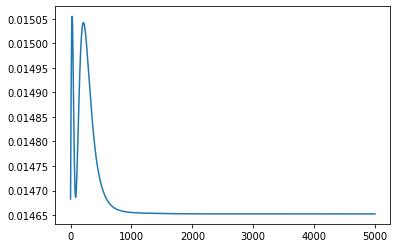

In [247]:
plt.plot(to_np(Ams.mean(dim=-2)[:, 70]))

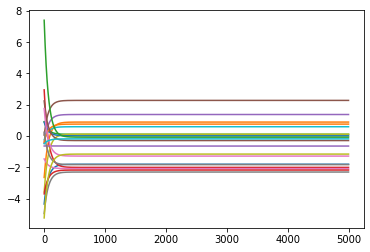

In [248]:
for i in range(20):
    plt.plot(to_np(torch.stack(steps['Km'])[:, 70, i]))

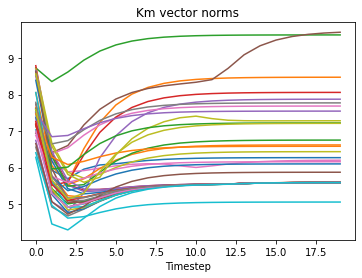

In [40]:
plt.title('Km vector norms')
plt.xlabel('Timestep')
plt.plot(Kms.norm(dim=-1).detach().cpu().numpy());

In [287]:
import something

Initializing Hopfield memories...
alpha: 0.1
use_adaptive_alpha: True
torch.Size([1, 12, 40, 40]) torch.Size([1, 12, 40, 80])


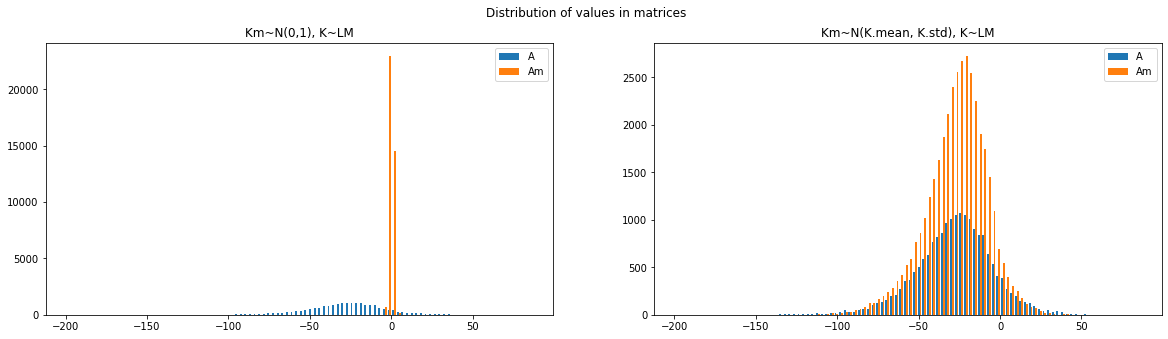

  0%|          | 0/3000 [00:00<?, ?it/s]

torch.Size([1, 12, 40, 80]) 0


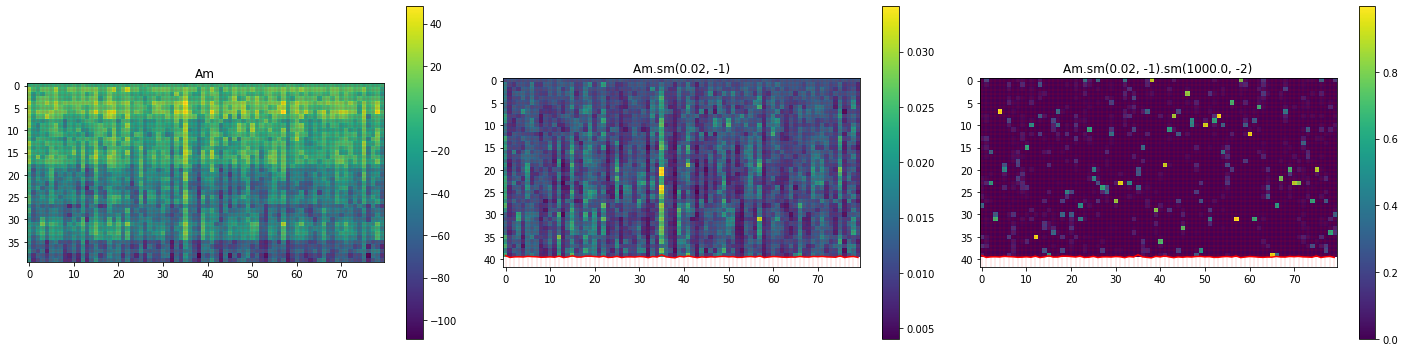

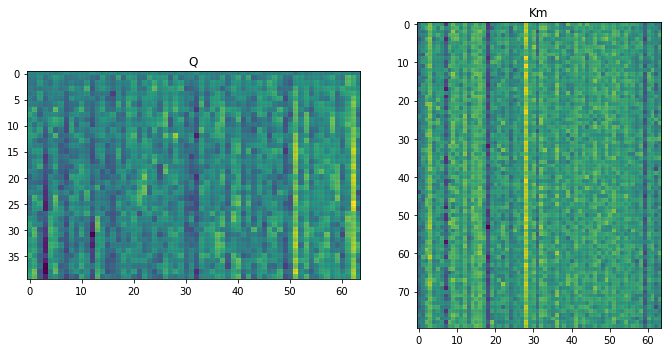

torch.Size([1, 12, 40, 80]) 0


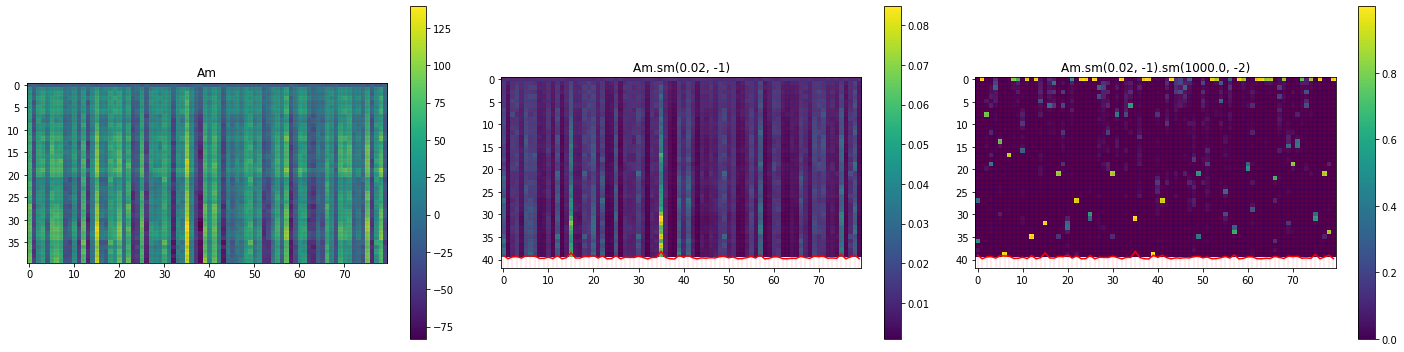

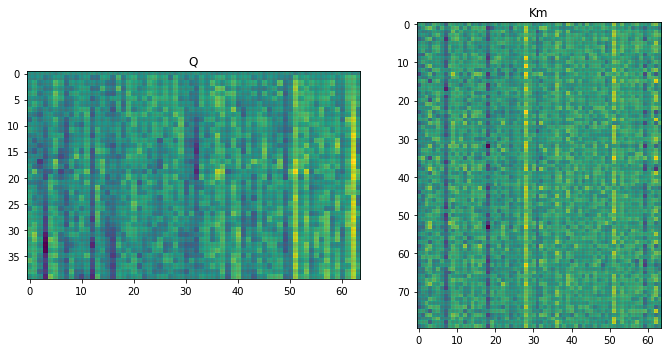

torch.Size([1, 12, 40, 80]) 0


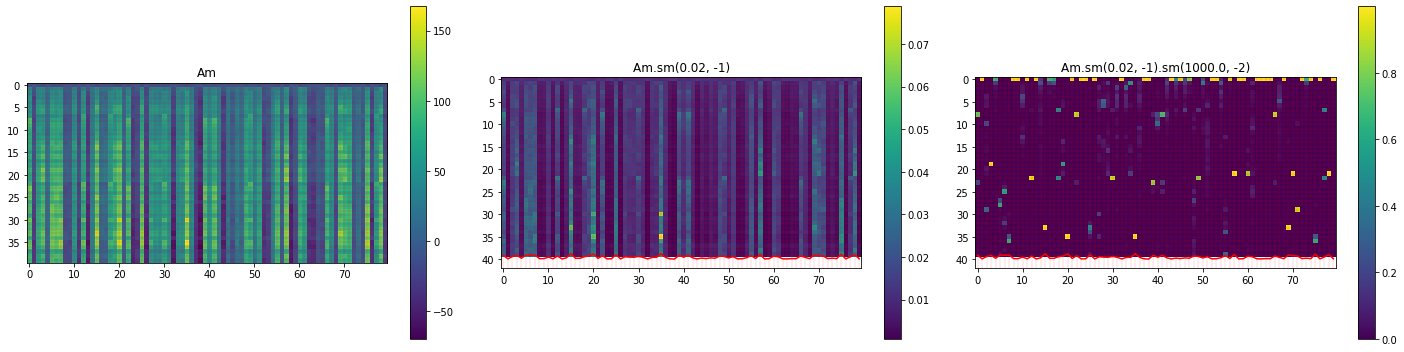

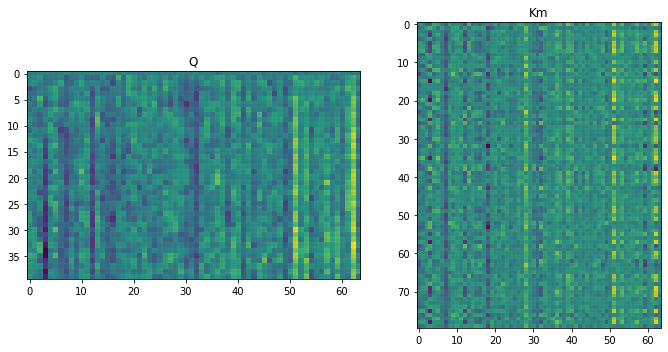

torch.Size([1, 12, 40, 80]) 0


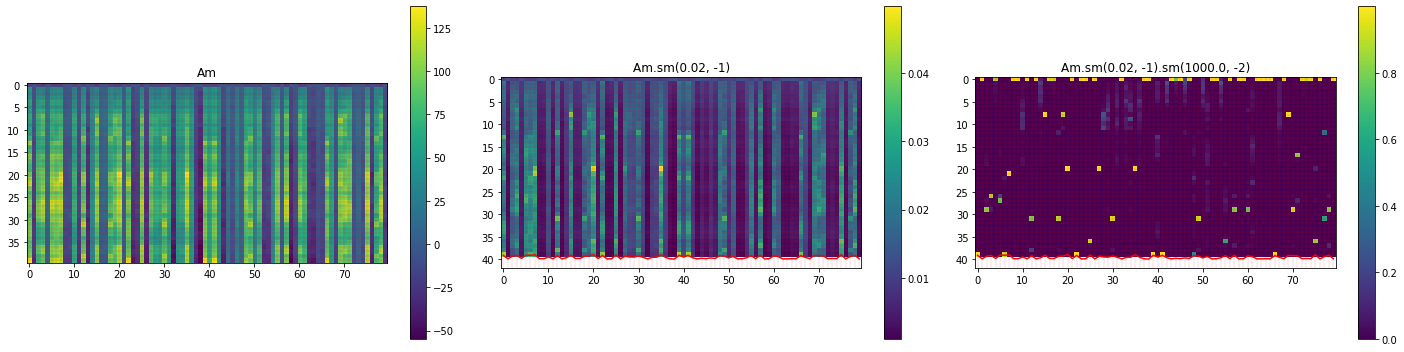

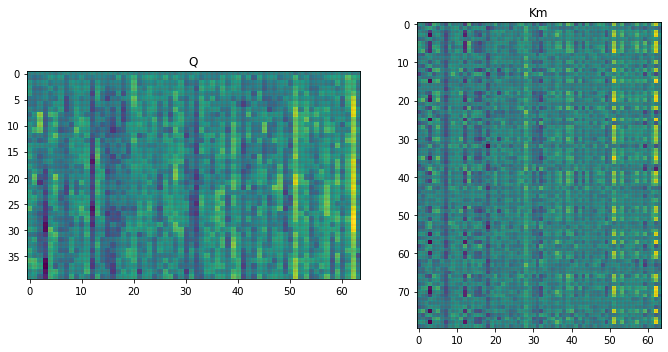

dict_keys(['idx_loop', 'tokens_context', 'nll_i', 'Km_spread', 'Q_spread'])


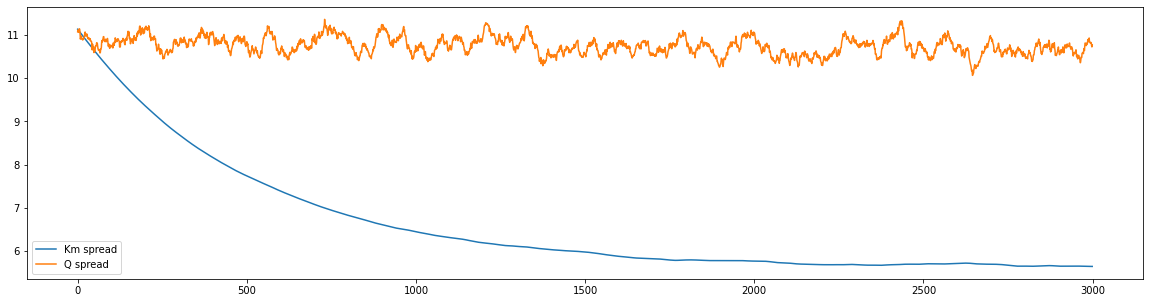

In [332]:
something.experiment(tokenizer, model, context_length=40, device=device, tqdm=tqdm, do_viz=True)